In [89]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [90]:
data = pd.read_csv('../../data/obesity_final.csv')


# Categorical variables encoding

In [91]:
cat = [column for column in data.columns if data[column].dtype == 'object']
cat

['gender',
 'family_history_with_overweight',
 'favc',
 'caec',
 'smoke',
 'scc',
 'calc',
 'mtrans',
 'nobeyesdad']

In [92]:
for i in cat:
     print(f"{i}: {data[i].unique()}")

gender: ['Female' 'Male']
family_history_with_overweight: ['yes' 'no']
favc: ['no' 'yes']
caec: ['Sometimes' 'Frequently' 'Always' 'no']
smoke: ['no' 'yes']
scc: ['no' 'yes']
calc: ['no' 'Frequently' 'Sometimes' 'Always']
mtrans: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
nobeyesdad: ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


## Ordinal encoding
For those categorical variables that have an intrinsic order 

In [93]:
from sklearn.preprocessing import OrdinalEncoder

# Crear una instancia de OrdinalEncoder
oe = OrdinalEncoder(categories=[
    ['no', 'Sometimes', 'Frequently', 'Always'],  # caec
    ['no', 'Frequently', 'Sometimes', 'Always'], # calc
    ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'] # nobeyesdad
])

# Encodear las variables categóricas con orden
data[['caec', 'calc', 'nobeyesdad']] = oe.fit_transform(data[['caec', 'calc', 'nobeyesdad']])



## Binary encoder

In [94]:
# Variables categóricas binarias
binary_categorical_vars = ['gender', 'family_history_with_overweight', 'favc', 'smoke', 'scc']

# Aplicar codificación binaria a las variables categóricas binarias
for binary in binary_categorical_vars:
    data[binary] = pd.get_dummies(data[binary], drop_first=True)

In [95]:
for i in ['gender',
 'family_history_with_overweight',
 'favc',
 'caec',
 'smoke',
 'scc',
 'calc',
 'mtrans',
 'nobeyesdad']:
     print(f"{i}: {data[i].unique()}")

gender: [False  True]
family_history_with_overweight: [ True False]
favc: [False  True]
caec: [1. 2. 3. 0.]
smoke: [False  True]
scc: [False  True]
calc: [0. 1. 2. 3.]
mtrans: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
nobeyesdad: [1. 2. 3. 4. 0. 5. 6.]


## One hot encoding
For those categorical variables that have more than 2 categories and don't have any order

In [96]:
# Crear un DataFrame de ejemplo con la variable categórica mtrans
df = pd.DataFrame(data)

# Aplicar one-hot encoding con drop_first=True
encoded_df = pd.get_dummies(df['mtrans'], drop_first=True)

# Concatenar el DataFrame original con las nuevas variables dummy
df_encoded = pd.concat([df, encoded_df], axis=1)
data = df_encoded.drop('mtrans', axis=1)

# RF 

## Basic RF 
https://www.yourdatateacher.com/2021/10/11/feature-selection-with-random-forest/

In [97]:
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

In [98]:
X = data.drop(columns=['nobeyesdad'])
y = data['nobeyesdad']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [100]:
rf = RandomForestClassifier(random_state=0)

rf.fit(X_train,y_train)


RandomForestClassifier(random_state=0)

In [101]:
features = data.columns.tolist()

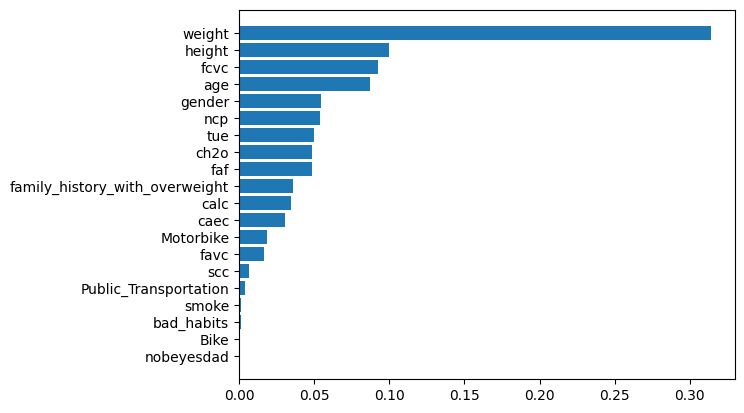

In [102]:
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

En la gráfica superior se aprecia la importanacia de las variables. Vemos que 'weight' es la variable que mejor predice la obesidad de los individuos. En un segundo escalón encontramos la altura, frecuencia de consumo de verduras, y edad. Y en un tercer escalón género, nº comidas principales al día, tiempo de uso de tencología, consumo de agua al día....
En cualquier caso vamos a optimizar los hiperparámetros del modelo y hacer kfold CV para obtener resultados más robustos.

## RF grid search

In [103]:
param_grid1 = {
    'n_estimators': [10,20],
    'criterion': ['entropy'],
    'max_depth': [None],
    'min_samples_split': [2,3,4],
    'max_features': ['sqrt'],
    'class_weight': ['balanced_subsample'],
    'n_jobs': [-1],
    'random_state':[42]
}

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid1)
grid.fit(X, y)
print("best mean cross-validation score =", grid.best_score_)
print(f"best parameters: {grid.best_params_}")
grid.best_estimator_
clf=grid.best_estimator_

best mean cross-validation score = 0.9298474468690495
best parameters: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 42}


In [105]:
import time
import numpy as np
start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.032 seconds


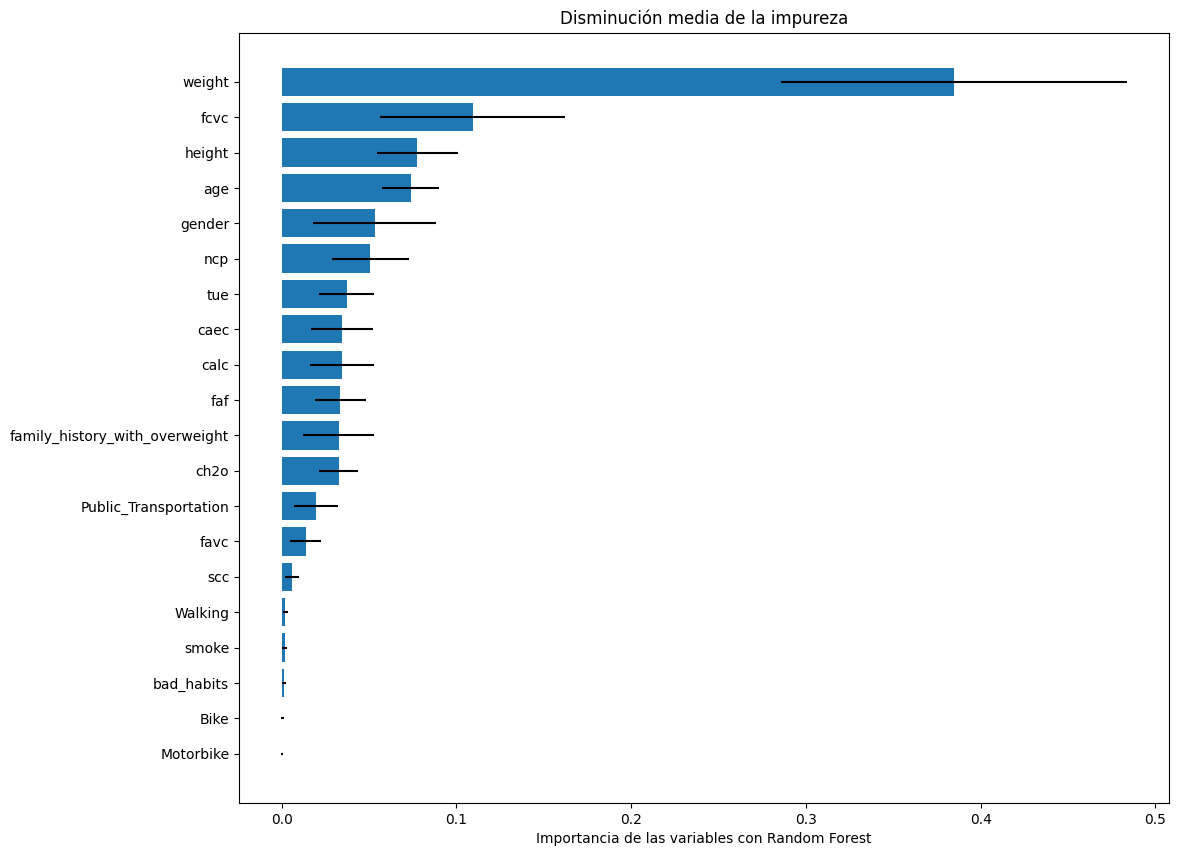

In [106]:
feature_names = X.columns
feature_names
#importances = forest.feature_importances_
#std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
sorted_idx = clf.feature_importances_.argsort()
ax, fig = plt.subplots(figsize=(12, 10))
plt.barh(feature_names[sorted_idx],clf.feature_importances_[sorted_idx],xerr= std[sorted_idx])
plt.xlabel('Importancia de las variables con Random Forest')
plt.title('Disminución media de la impureza')
plt.show()

Misma interpretación, pero vemos como la importancia de las variables a partir del segundo puesto cambia. Los bigotes muestran cuánto podemos esperar que varíen esos efectos o contribuciones.


In [107]:
datos_feature_ros= {'variables': feature_names[sorted_idx],'importancia':clf.feature_importances_[sorted_idx]}
dfdatos_feature_ros= pd.DataFrame(datos_feature_ros)
dfdatos_feature_ros.iloc[::-1]

,variables,importancia
19,weight,0.384753
18,fcvc,0.109232
17,height,0.077582
16,age,0.073835
15,gender,0.053207
14,ncp,0.050779
13,tue,0.037363
12,caec,0.034608
11,calc,0.034527
10,faf,0.033620


## RF Optuna
Optimization of hyperparammeters by using Optuna

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import optuna


In [128]:
import optuna
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Definir la función de objetivo para optimizar los hiperparámetros
def objective(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Construir el clasificador RandomForest con los hiperparámetros sugeridos
    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    
     # Validación cruzada con K-Fold
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Entrenar el clasificador y calcular la precisión
        rf_clf.fit(X_train, y_train)
        y_pred = rf_clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)



    return sum(accuracies) / len(accuracies)

In [133]:
# Crear un estudio Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-04-10 17:24:08,953] A new study created in memory with name: no-name-66e8f10d-f15e-4cdd-ad70-004a703c1d46
[I 2024-04-10 17:24:09,775] Trial 0 finished with value: 0.16433021806853582 and parameters: {'n_estimators': 83, 'max_depth': 2, 'min_samples_split': 0.9126289593167806, 'min_samples_leaf': 0.11859042803027897, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.16433021806853582.
[I 2024-04-10 17:24:10,350] Trial 1 finished with value: 0.16433021806853582 and parameters: {'n_estimators': 57, 'max_depth': 2, 'min_samples_split': 0.4993885146855548, 'min_samples_leaf': 0.41780835380259784, 'max_features': 'log2'}. Best is trial 0 with value: 0.16433021806853582.
[I 2024-04-10 17:24:10,817] Trial 2 finished with value: 0.16433021806853582 and parameters: {'n_estimators': 46, 'max_depth': 6, 'min_samples_split': 0.34356823192466046, 'min_samples_leaf': 0.372972847406948, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.16433021806853582.
[I 2024-04-10 17:24:11,196] T

In [134]:
model =RandomForestClassifier(**study.best_params)
model.fit(X,y)

RandomForestClassifier(max_depth=8, min_samples_leaf=0.11424731023256396,
                       min_samples_split=0.17992416640729963, n_estimators=91)

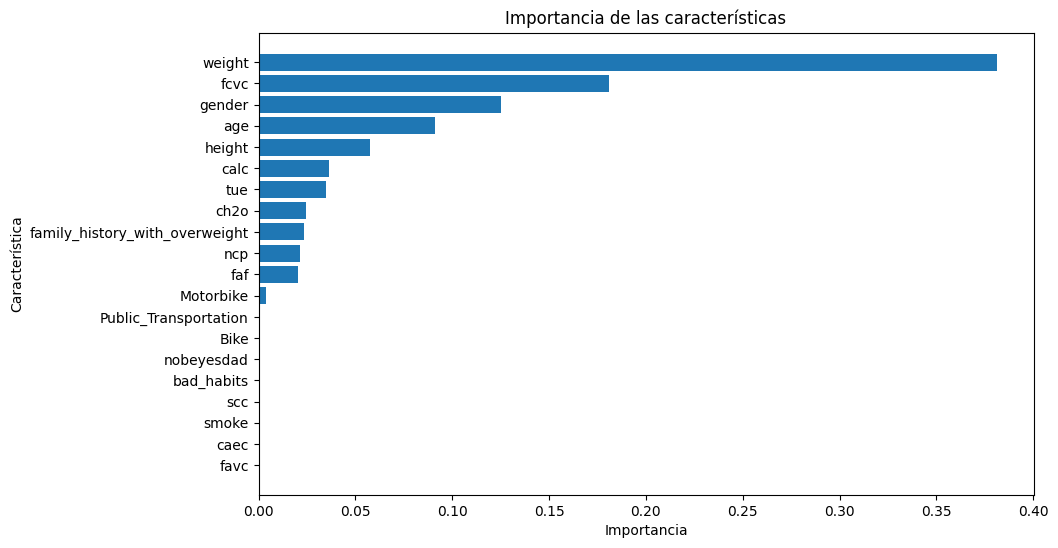

In [135]:
import matplotlib.pyplot as plt

# Obtener las características y sus importancias
feature_importances = list(zip(features, model.feature_importances_))

# Ordenar las características según su importancia
feature_importances.sort(key=lambda x: x[1])

# Crear un gráfico de barras horizontales de la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in feature_importances], [x[1] for x in feature_importances])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las características')
plt.show()

In [136]:
# Definir el umbral de importancia
threshold = 0.05  # Puedes ajustar este valor según tus necesidades

# Filtrar las características por encima del umbral
important_features = [feature[0] for feature in feature_importances if feature[1] > threshold]

# Imprimir las características seleccionadas
print("Características seleccionadas:", important_features)


Características seleccionadas: ['height', 'age', 'gender', 'fcvc', 'weight']


In [124]:
# Crear un nuevo DataFrame de características con solo las características seleccionadas
selected_features_df = X[important_features]

In [127]:
selected_features_df

,height,age,family_history_with_overweight,gender,fcvc,weight
0,162.0,21,True,False,2.00,64.0
1,180.0,23,True,True,2.00,77.0
2,180.0,27,False,True,3.00,87.0
3,178.0,22,False,True,2.00,89.8
4,162.0,29,False,True,2.00,53.0
...,...,...,...,...,...,...
2131,191.0,30,True,True,2.10,129.0
2132,187.0,31,True,True,2.73,127.0
2133,190.0,30,True,True,2.22,129.0
2134,184.0,31,True,True,2.49,125.0


# Selected variables description

In [137]:
# Realizar un análisis estadístico de cada característica
summary_statistics = selected_features_df.describe()

# Imprimir el análisis estadístico
print(summary_statistics)

            height          age         fcvc       weight
count  2136.000000  2136.000000  2136.000000  2136.000000
mean    169.817884    23.911049     2.418132    85.985534
std       9.295920     6.300481     0.534713    26.133833
min     145.000000    14.000000     1.000000    39.000000
25%     163.000000    19.000000     2.000000    65.000000
50%     170.000000    22.000000     2.390000    82.500000
75%     176.000000    26.000000     3.000000   106.250000
max     198.000000    61.000000     3.000000   173.000000


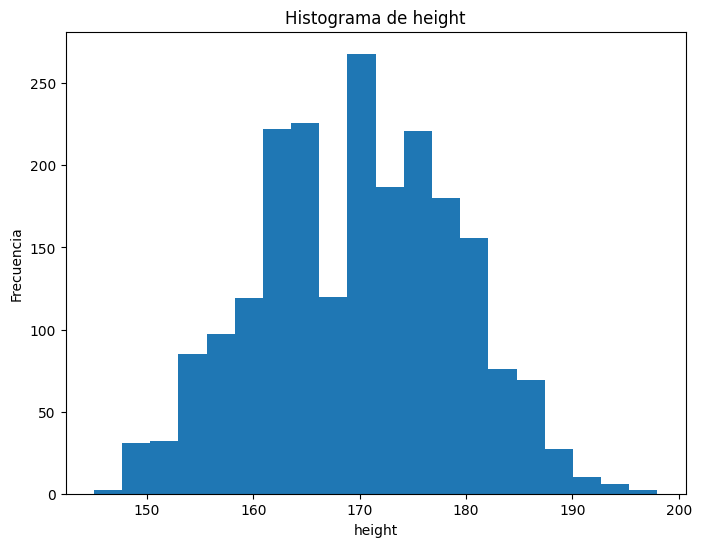

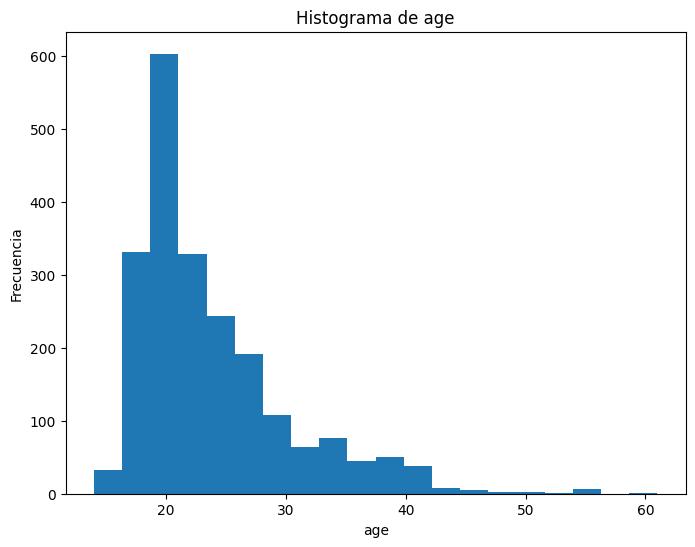

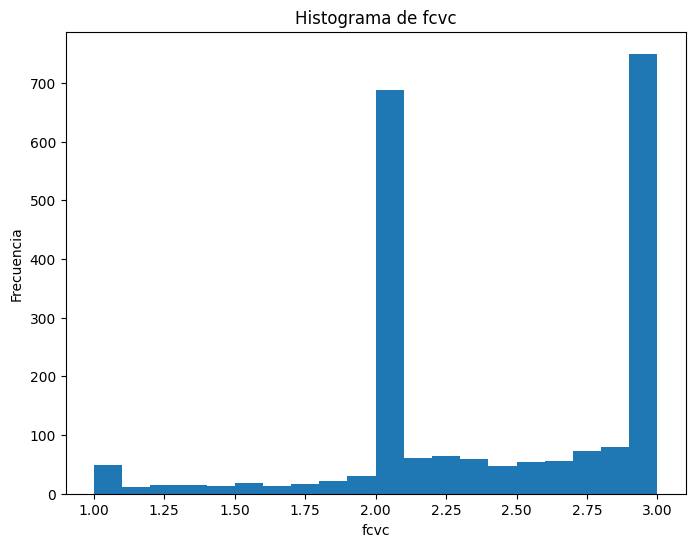

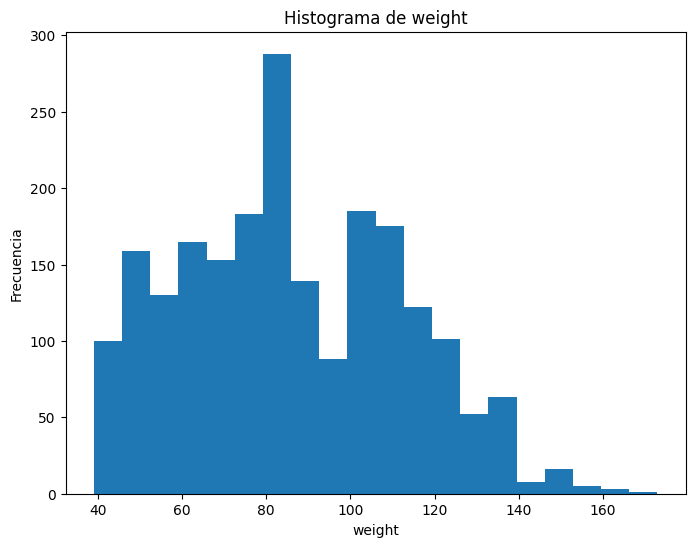

In [145]:
# Convertir todas las columnas a tipo numérico
numeric_features = selected_features_df.select_dtypes(include=['number']).columns.tolist()


# Obtener histogramas para cada variable seleccionada
for column in numeric_features:
    plt.figure(figsize=(8, 6))
    selected_features_df[column].hist(bins=20)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(False)
    plt.show()

c:\Users\usuario\anaconda3\envs\TFGr\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\usuario\anaconda3\envs\TFGr\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\usuario\anaconda3\envs\TFGr\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\usuario\anaconda3\envs\TFGr\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

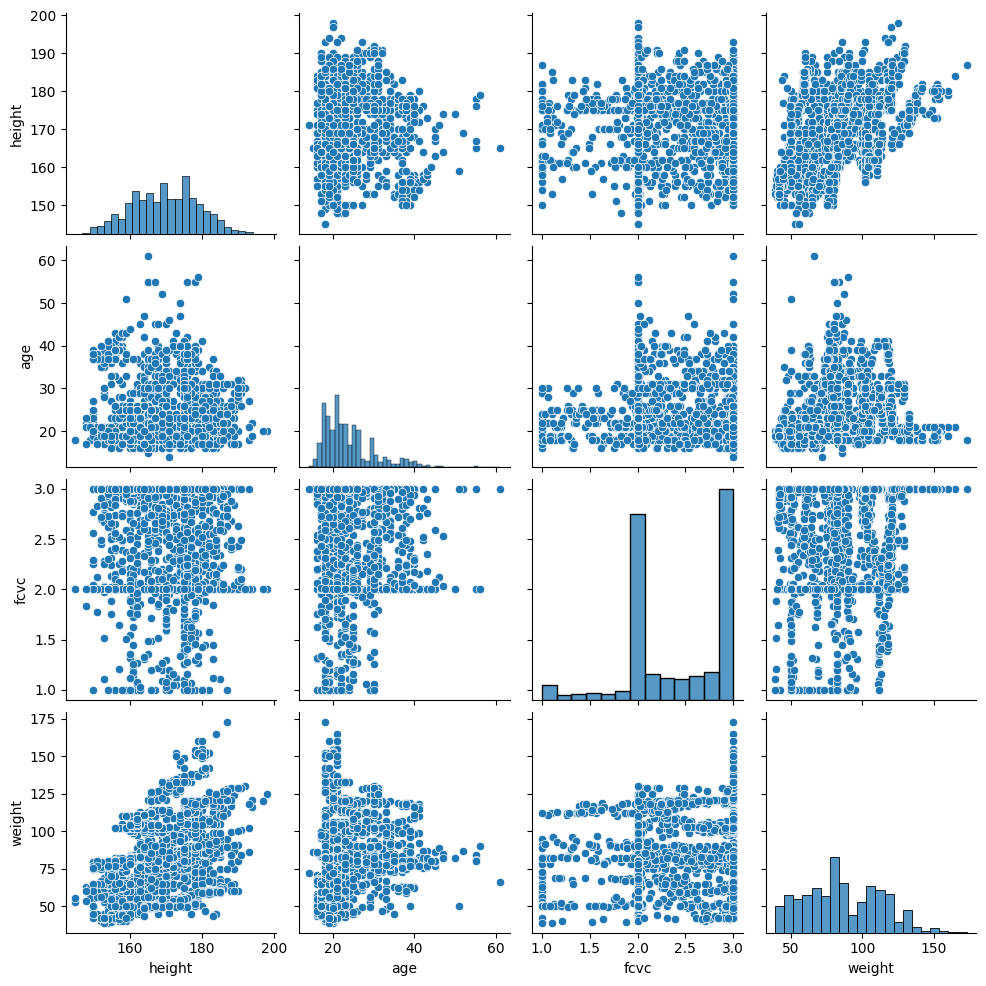

In [149]:
import seaborn as sns

# Crear un pairplot de todas las combinaciones de variables numéricas
sns.pairplot(selected_features_df[numeric_features])
plt.show()

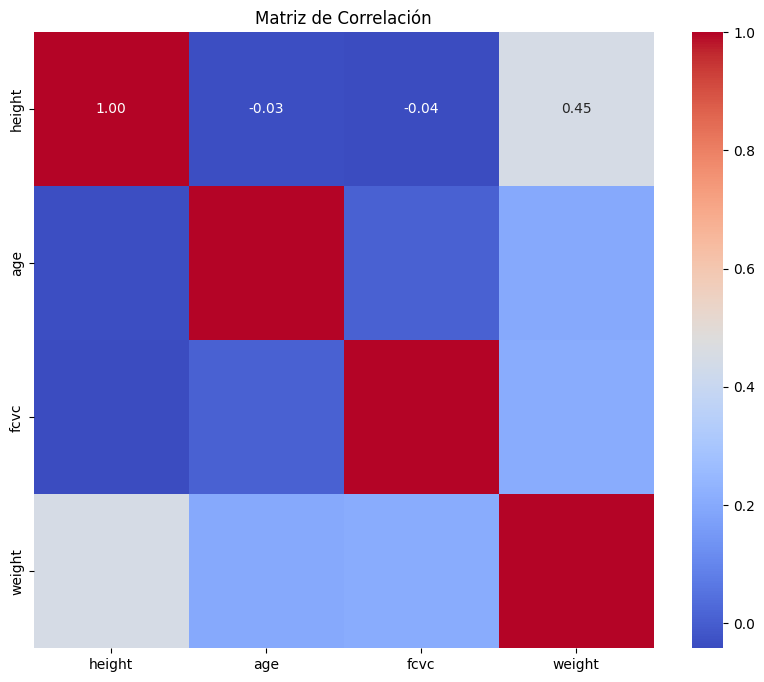

In [151]:
# Calcular la matriz de correlación
correlation_matrix = selected_features_df[numeric_features].corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()